# Timeseries Forcasting with Prophet Model

## import packages

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prophet
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## import data from API

we can get the data from this two sites:\
1- twelvedata.com\
2- alphavantage.co

In [ ]:
#pip install twelvedata

In [126]:
from twelvedata import TDClient

def get_price(Symbol, Interval, n_interval):
    # Initialize client - apikey parameter is requiered
    td = TDClient(apikey="???")

    # Construct the necessary time series
    ts = td.time_series(
        symbol= Symbol,
        interval= Interval,
        outputsize= n_interval,
        #timezone="America/New_York",
    )

    # Returns pandas.DataFrame
    df= ts.as_pandas()
    return df

dataset = get_price('GSPC', '4h', 5000)  #BTC/USD
dataset

,open,high,low,close,volume
datetime,,,,,
2022-11-23 13:30:00,4011.18994,4033.78003,4007.97998,4027.86011,7358000
2022-11-23 09:30:00,4000.30005,4029.65991,3998.65991,4011.12988,1814646
2022-11-22 13:30:00,3989.31006,4005.87988,3986.58008,4003.64990,675675000
2022-11-22 09:30:00,3965.51001,3989.84009,3956.87988,3989.34009,956396646
2022-11-21 13:30:00,3954.40991,3960.36011,3945.23999,3950.25000,672934000
...,...,...,...,...,...
2020-02-25 11:00:00,3199.57007,3203.13989,3123.04004,3143.16992,1315166706
2020-02-25 07:00:00,3238.93994,3246.98999,3186.83008,3199.33008,635842385
2020-02-24 15:00:00,3248.90991,3253.58008,3225.82007,3225.82007,556997955


## check and fill the missvalues

In [127]:
dataset.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

## preparing the data for the prophet model

In [128]:
dataset['datetime'] = dataset.index
df = dataset[['datetime','close']]
df

,datetime,close
datetime,,
2022-11-23 13:30:00,2022-11-23 13:30:00,4027.86011
2022-11-23 09:30:00,2022-11-23 09:30:00,4011.12988
2022-11-22 13:30:00,2022-11-22 13:30:00,4003.64990
2022-11-22 09:30:00,2022-11-22 09:30:00,3989.34009
2022-11-21 13:30:00,2022-11-21 13:30:00,3950.25000
...,...,...
2020-02-25 11:00:00,2020-02-25 11:00:00,3143.16992
2020-02-25 07:00:00,2020-02-25 07:00:00,3199.33008
2020-02-24 15:00:00,2020-02-24 15:00:00,3225.82007


In [129]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1400 entries, 2022-11-23 13:30:00 to 2020-02-24 07:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   open      1400 non-null   float64       
 1   high      1400 non-null   float64       
 2   low       1400 non-null   float64       
 3   close     1400 non-null   float64       
 4   volume    1400 non-null   int64         
 5   datetime  1400 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 76.6 KB


In [130]:
df.columns = ['ds', 'y']
df = df.reset_index()
df = df.drop('datetime', axis=1)
df

,ds,y
0,2022-11-23 13:30:00,4027.86011
1,2022-11-23 09:30:00,4011.12988
2,2022-11-22 13:30:00,4003.64990
3,2022-11-22 09:30:00,3989.34009
4,2022-11-21 13:30:00,3950.25000
...,...,...
1395,2020-02-25 11:00:00,3143.16992
1396,2020-02-25 07:00:00,3199.33008
1397,2020-02-24 15:00:00,3225.82007
1398,2020-02-24 11:00:00,3248.67993


In [136]:
df= df.sort_index(ascending=False)
df

,ds,y
1399,2020-02-24 07:00:00,3249.58008
1398,2020-02-24 11:00:00,3248.67993
1397,2020-02-24 15:00:00,3225.82007
1396,2020-02-25 07:00:00,3199.33008
1395,2020-02-25 11:00:00,3143.16992
...,...,...
4,2022-11-21 13:30:00,3950.25000
3,2022-11-22 09:30:00,3989.34009
2,2022-11-22 13:30:00,4003.64990
1,2022-11-23 09:30:00,4011.12988


In [137]:
p = Prophet()
p.fit(df)

23:36:50 - cmdstanpy - INFO - Chain [1] start processing
23:36:50 - cmdstanpy - INFO - Chain [1] done processing


In [138]:
future = p.make_future_dataframe(periods=200 , freq='4h')
future.tail()

,ds
1595,2022-12-26 05:30:00
1596,2022-12-26 09:30:00
1597,2022-12-26 13:30:00
1598,2022-12-26 17:30:00
1599,2022-12-26 21:30:00


In [139]:
print(df.shape)
print(future.shape)

(1400, 2)
(1600, 1)


In [140]:
forecast = p.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-24 07:00:00,-3431.022219,2995.102221,3200.207684,-3431.022219,-3431.022219,6531.209847,6531.209847,6531.209847,6583.646033,...,-8.974770,-8.974770,-8.974770,-43.461416,-43.461416,-43.461416,0.0,0.0,0.0,3100.187628
1,2020-02-24 11:00:00,-3430.646479,2938.793504,3137.874784,-3430.646479,-3430.646479,6468.066682,6468.066682,6468.066682,6520.195566,...,-7.180823,-7.180823,-7.180823,-44.948060,-44.948060,-44.948060,0.0,0.0,0.0,3037.420204
2,2020-02-24 15:00:00,-3430.270739,2980.041468,3180.240073,-3430.270739,-3430.270739,6516.201732,6516.201732,6516.201732,6567.643795,...,-5.019493,-5.019493,-5.019493,-46.422570,-46.422570,-46.422570,0.0,0.0,0.0,3085.930993
3,2020-02-25 07:00:00,-3428.767778,2996.794152,3198.306513,-3428.767778,-3428.767778,6528.927019,6528.927019,6528.927019,6583.646033,...,-2.532696,-2.532696,-2.532696,-52.186318,-52.186318,-52.186318,0.0,0.0,0.0,3100.159240
4,2020-02-25 11:00:00,-3428.392038,2930.966243,3135.481391,-3428.392038,-3428.392038,6462.754538,6462.754538,6462.754538,6520.195566,...,-3.850484,-3.850484,-3.850484,-53.590544,-53.590544,-53.590544,0.0,0.0,0.0,3034.362500


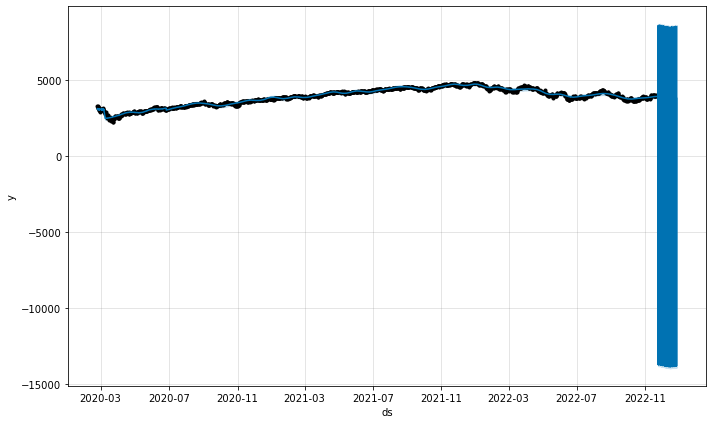

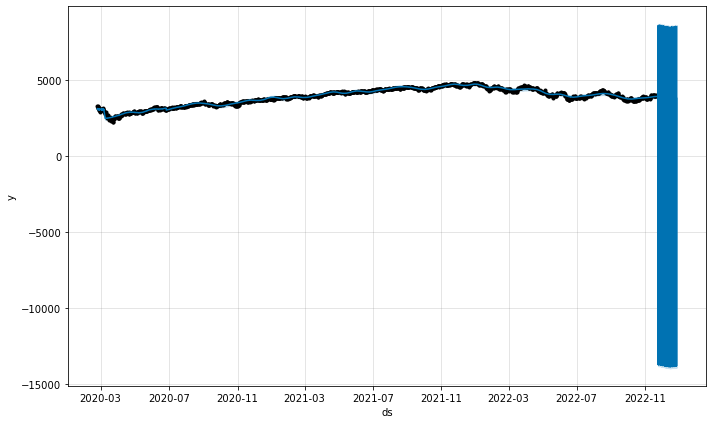

In [135]:
p.plot(forecast)